In [8]:
import qiskit
from qiskit import QuantumCircuit, Aer, QuantumRegister, IBMQ
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

In [9]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
IBMQ.save_account('96550e2aeb56e9e0fbcc3704c711f213ecf227b108f15eebb14874955a1737a79dc52e116101c78d39d27912423ea0539096bcca1986fce0dd5a36730866af4a')

configrc.store_credentials:WARNING:2022-10-10 02:27:59,932: Credentials already present. Set overwrite=True to overwrite.


## 1.マシンのノイズモデルを取得

In [10]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_manila')
noise_model = noise.NoiseModel.from_backend(backend)
print(noise_model)

ibmqfactory.load_account:WARNING:2022-10-10 02:28:00,363: Credentials are already in use. The existing account in the session will be replaced.


NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'cx', 'id', 'measure', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


## 2.ノイズモデルを用いて校正用のデータを作成

In [11]:
qr = qiskit.QuantumRegister(5)
qubit_list = [0, 1, 2, 3, 4]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

校正用データを得るために実行する量子回路(meas_calibs)とラベル(state_labels)を生成し、実行。

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


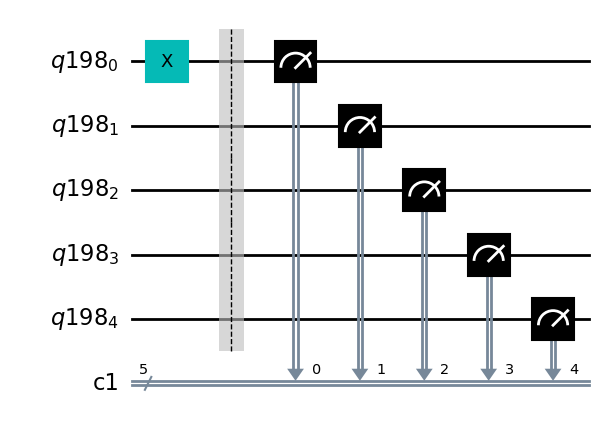

In [12]:
print(state_labels)
meas_calibs[1].draw('mpl')

測定結果から校正用の行列を生成し、プロット。行列は、用意された状態に対する測定された状態の分布を示し、２つの状態は一致するため、identity matrixになるはずである。しかし、実際のマシンのノイズモデルを入れて計算すると、下記のように非対角成分も値を持つ。

[[0.914 0.024 0.038 ... 0.    0.    0.   ]
 [0.024 0.901 0.001 ... 0.    0.    0.   ]
 [0.012 0.    0.905 ... 0.    0.001 0.   ]
 ...
 [0.    0.    0.    ... 0.829 0.    0.041]
 [0.    0.    0.    ... 0.001 0.802 0.026]
 [0.    0.    0.    ... 0.01  0.023 0.795]]


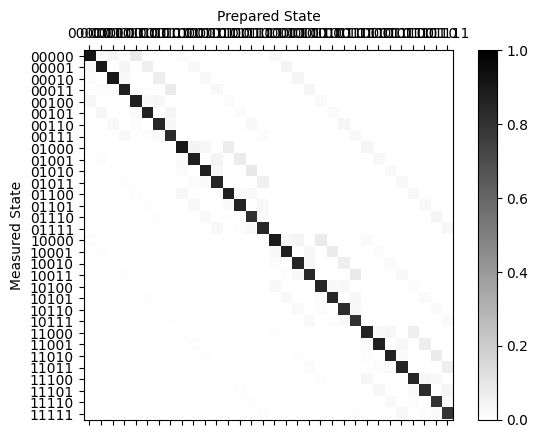

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list)
print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

## 3. 校正行列を用いてエラーを軽減
校正行列を用いて、量子コンピュータから得られたエラーを含む出力結果からもとの値を”逆算”することでエラーの影響が軽減された結果が得られる。\\
ここでは

In [14]:
qc = QuantumCircuit(5, 5)

qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure(0, 0)
qc.measure(2, 2)

# qc.draw('mpl')

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_manila')
job = qiskit.execute(qc, backend=backend, shots=1000)
results = job.result()
print(results.get_counts())

ibmqfactory.load_account:WARNING:2022-10-10 02:28:09,107: Credentials are already in use. The existing account in the session will be replaced.


{'00000': 495, '00001': 68, '00100': 47, '00101': 390}


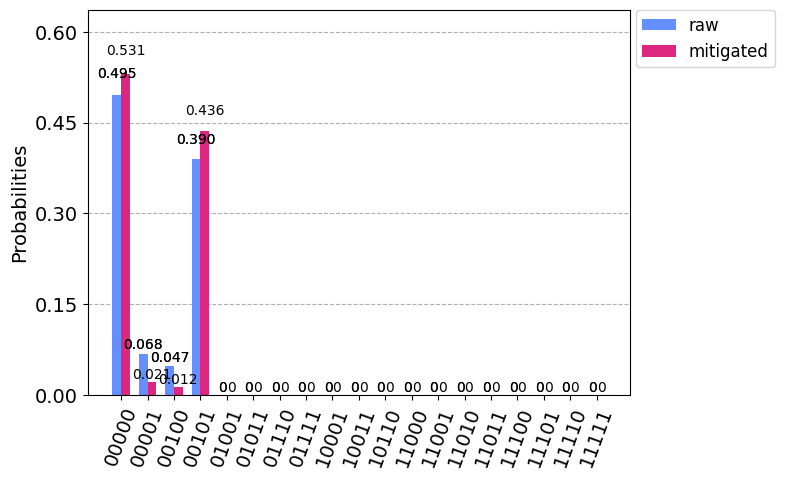

In [16]:
#測定された生の値
raw_counts = results.get_counts()

#較正行列により補正した値
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])